In [11]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import json

In [9]:
current_dir = os.getcwd()
results = pd.read_csv(current_dir + '/MISA/results_mosei_MISA_dropout(0.6)-batchsize(32).csv')

In [14]:
results_json = current_dir + '/MISA/results_MISA_baseline_dropout(0.6)-batchsize(32)_epoch(10).json'
with open(results_json) as f:
    results_dict = json.load(f)

results_dict

{'loss': 2.9492771723499036,
 'accuracy': 0.416,
 'precision': 0.4169984420979747,
 'recall': 0.7614983404457089,
 'f1': 0.538896034897377,
 'acc_va': 0.3238,
 'acc_ta': 0.4084,
 'acc_tv': 0.4057,
 'acc_t': 0.4284,
 'acc_v': 0.2507,
 'acc_a': 0.2711}

In [15]:
'''confidNet results
labels: ['happiness', 'sadness', 'anger', 'fear', 'disgust', 'surprise']
'''
results.head()

,id,input_sentence,label,prediction,predicted_scores,tcp_TVA,tcp_AV,tcp_TA,tcp_TV,tcp_T,tcp_V,tcp_A
0,-6rXp3zJ3kc[1],very aware of many people are not until they g...,[0. 1. 0. 0. 0. 0.],[1. 1. 1. 0. 0. 0.],[0.4516461 0.46656027 0.38578466 0.33558005 0...,0.466560,0.433204,0.472289,0.434720,0.422204,0.457258,0.399891
1,-AUZQgSxyPQ[0],the perfect soul mate to the spot therapy brus...,[0. 0. 0. 0. 0. 1.],[1. 0. 0. 0. 0. 0.],[0.64966536 0.3337268 0.24920052 0.2128066 0...,0.253617,0.327510,0.285556,0.226512,0.292095,0.366067,0.248023
2,-6rXp3zJ3kc[2],so the answer to the question can i contribute...,[0. 1. 0. 0. 0. 0.],[1. 1. 1. 0. 0. 0.],[0.44839808 0.3952209 0.36040866 0.25261754 0...,0.395221,0.439653,0.389881,0.362032,0.430737,0.453138,0.327815
3,-MeTTeMJBNc[3],picture maybe you could find a picture of the ...,[1. 0. 0. 1. 0. 0.],[1. 1. 0. 0. 0. 0.],[0.50492644 0.40333834 0.32755247 0.29555866 0...,0.400243,0.345079,0.417042,0.379987,0.290894,0.339653,0.383099
4,-RfYyzHpjk4[3],time you can use it for personal use family fr...,[1. 0. 1. 0. 1. 0.],[1. 0. 0. 0. 0. 0.],[0.5898261 0.30789584 0.24227029 0.1855425 0...,0.315820,0.318744,0.333613,0.314372,0.323015,0.333642,0.335239


In [16]:
print(len(results))

4654


In [18]:
results['label'].loc[lambda x: x =='[0. 0. 0. 0. 0. 0.]'].count()

701

In [19]:
# Drop the rows with no label
results = results[results['label'] != '[0. 0. 0. 0. 0. 0.]']
print(results.shape[0])

3953


In [23]:
text_is_noise = results[results['tcp_AV'] > results['tcp_TVA']]
audio_is_noise = results[results['tcp_TA'] > results['tcp_TVA']]
video_is_noise = results[results['tcp_TV'] > results['tcp_TVA']]

In [24]:
# Modality noise counts with no label rows dropped
print("Total counts: ", results.shape[0])
print("Textual noise counts: ", text_is_noise.shape[0])
print("Visual noise counts: ", video_is_noise.shape[0])
print("Audio noise counts: ", audio_is_noise.shape[0])

Total counts:  3953
Textual noise counts:  785
Visual noise counts:  1187
Audio noise counts:  3258


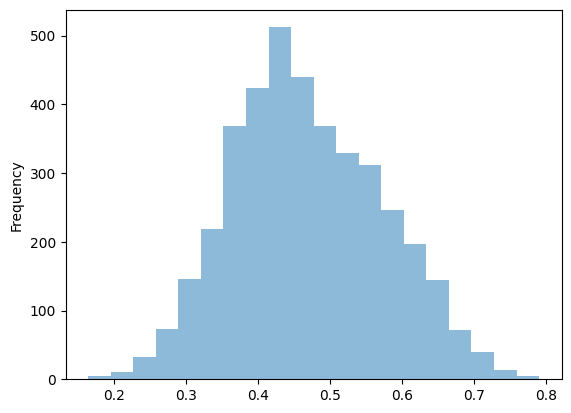

In [25]:
ax = results['tcp_TVA'].plot.hist(bins=20, alpha=0.5)

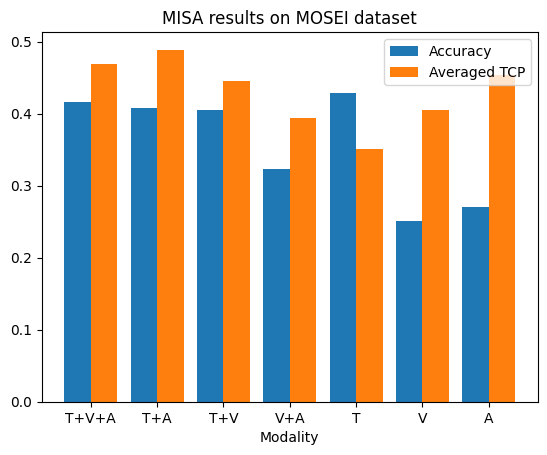

In [30]:
columns = ['T+V+A', 'T+A', 'T+V', 'V+A', 'T', 'V', 'A']
X_axis = np.arange(len(columns))

accuracy = [
    results_dict['accuracy'], results_dict['acc_ta'], results_dict['acc_tv'], results_dict['acc_va'], results_dict['acc_t'], results_dict['acc_v'], results_dict['acc_a']
]

average_tcp = [
    np.mean(results['tcp_TVA']), 
    np.mean(results['tcp_TA']), 
    np.mean(results['tcp_TV']), 
    np.mean(results['tcp_AV']), 
    np.mean(results['tcp_T']),
    np.mean(results['tcp_V']), 
    np.mean(results['tcp_A'])
]

# histogram of the data
plt.bar(X_axis - 0.2, accuracy, 0.4, label = 'Accuracy')
plt.bar(X_axis + 0.2, average_tcp, 0.4, label = 'Averaged TCP')

plt.xticks(X_axis, columns)
plt.xlabel("Modality")
plt.title("MISA results on MOSEI dataset")
plt.legend()
plt.show()